In [2]:
import torch
import pandas as pd
import time
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [3]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [4]:
dev.type


'cuda'

In [5]:
twits = pd.read_csv('train.csv', engine='python')

In [5]:
#twits[:2]

In [6]:
#twits.shape

In [7]:
todelete = []
clines = twits.shape[0]
# clean twits
for nline in tqdm(range(clines)):
    line = twits.iloc[nline,2]
    line = line.lower()
    
    # remove &xx
    line = re.sub(r'&\S*', '', line)
    # change all @nicks to @twuser
    line = re.sub(r'@\S*', '@twuser', line)
    # change all ......... to ...
    line = re.sub(r'\.+', ' ...', line)
    # remove all . , : ; ( ) after text
    line = re.sub(r'(\S)[\.\,\:\;\)\(]', r'\1', line)
    # remove all . , : ; ( ) before text
    line = re.sub(r'[\.\,\:\;\)\(](\S)', r'\1', line)
    # remove -*
    line = re.sub(r'-\*', '', line)
    # change ))))) -> ) и (((( -> (
    line = re.sub(r'\)+', '\)', line)
    line = re.sub(r'\(+', '\(', line)
    # нафик фигню
    line = re.sub(r'\\\\[\(\)]', '', line)
    line = re.sub(r'(\S)\- ', r'\1 ', line)
    line = re.sub(r'(\S)\- ', r'\1 ', line)
    #line = re.sub(r'[^a-z 0-9\,\.\=\-\(\)\[\]\:\;\'\+]', '', line)    
    # убрать ссылки
    line = re.sub(r'http:\S*', '', line)
    line = re.sub(r'www.\S*', '', line)
    # убрать много минусов, воскл, вопр знаков
    line = re.sub(r'[\-]+', ' - ', line)
    line = re.sub(r'[\!]+', ' ! ', line)
    line = re.sub(r'[\?]+', ' ? ', line)
    # заменить 3 и более символов на один
    line = re.sub(r'([\S])\1{3,}', r'\1', line)
    # фигня в начале
    line = re.sub(r'(^[^\w]+)', '', line)
    # 2 пробела -> один
    line = re.sub(r' +', ' ', line)
    
#     line = re.sub(r'', '', line)
#     line = re.sub(r'', '', line)
#     line = re.sub(r'', '', line)
#     line = re.sub(r'', '', line)
#     line = re.sub(r'', '', line)
#     line = re.sub(r'', '', line)
    
    line = line.strip()
    
    if len(line) > 0:
        twits.iloc[nline,2] = line
    else:
        todelete.append(nline)
    
for i in sorted(todelete, reverse = True):
    twits.drop(twits.index[[i]], inplace = True)
    

100%|██████████| 99989/99989 [12:26<00:00, 134.02it/s]


In [8]:
line = "this р°р»сњс-рѕрµс† 22"
re.sub(r'[^a-z 0-9\,\.\=\-\(\)\[\]\:\;\'\+]', '', line)

'this - 22'

In [6]:
line = ",really not; fun. :) go"
re.sub(r'[\.\,\:\;](\S)', r'\1', line)

'really not; fun. ) go'

In [8]:
twits.to_csv("train_amended2.csv", index=False)

In [10]:
twits = pd.read_csv('train_amended2.csv', engine='python')

In [9]:
# twits 2 lists
clines = twits.shape[0]
phrases = []
tonality = torch.zeros(clines, dtype=torch.int64).to(dev)


for nline in range(clines):
    phrases.append(twits.iloc[nline,2])
    tonality[nline] = torch.tensor(twits.iloc[nline,1])

In [10]:
type(twits.iloc[nline,1])

numpy.int64

In [11]:
tonality


tensor([0, 0, 1,  ..., 0, 1, 1], device='cuda:0')

In [12]:
text = ' '.join(phrases)
ALL_WORDS = set(text.strip().split(' '))
len(ALL_WORDS)

63600

In [13]:
from collections import Counter

In [14]:
c = Counter(text.split(' '))
c.most_common(10)

[('twuser', 83256),
 ('.', 64374),
 ('i', 49306),
 ('!', 42278),
 ('the', 29715),
 ('to', 29652),
 ('you', 26942),
 ('a', 22917),
 ('it', 17430),
 ('?', 17154)]

In [15]:
len(c.keys())

63600

In [16]:
# удаляем слова с числом повторений меньше 3
todelete = set()
for i, n in c.items():
    if n < 3:
        todelete.add(i)
        
for i in todelete:
    del c[i]

In [17]:
len(c.keys())

16034

In [18]:
twits.shape

(99984, 3)

In [19]:
WORDS_COUNT = len(ALL_WORDS)
ALL_WORDS = set([w for w, _ in c.most_common(WORDS_COUNT)])
INDEX_TO_WORD = ['<pad>', '<miss>'] + list(ALL_WORDS)
len(INDEX_TO_WORD)

16036

In [20]:
WORD_TO_INDEX = {w: i for i, w in enumerate(INDEX_TO_WORD)}
INDEX_TO_WORD[:10]

['<pad>',
 '<miss>',
 'slipped',
 'house',
 'slr',
 'chilly',
 '#samesexsunday',
 'that',
 '.both',
 'suggested']

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([3.8970e+03, 1.2296e+04, 9.6800e+03, 1.4618e+04, 1.3057e+04,
        7.6980e+03, 1.0378e+04, 9.5070e+03, 6.1200e+03, 7.8060e+03,
        4.0120e+03, 7.0500e+02, 1.6900e+02, 2.1000e+01, 5.0000e+00,
        5.0000e+00, 6.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.  ,   3.66,   6.32,   8.98,  11.64,  14.3 ,  16.96,  19.62,
         22.28,  24.94,  27.6 ,  30.26,  32.92,  35.58,  38.24,  40.9 ,
         43.56,  46.22,  48.88,  51.54,  54.2 ,  56.86,  59.52,  62.18,
         64.84,  67.5 ,  70.16,  72.82,  75.48,  78.14,  80.8 ,  83.46,
         86.12,  88.78,  91.44

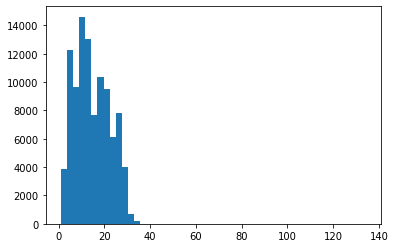

In [22]:
# распреление длины слов в строке
plt.hist([len(s.split(' ')) for s in phrases], bins=50)

In [23]:
MAX_LEN = 35

In [24]:
X = torch.zeros((len(phrases), MAX_LEN), dtype=int)

In [25]:
# готовим матрицу - строка - фраза, столбец - индекс слова в этой позиции
for i in tqdm(range(len(phrases))):
    for j, w in enumerate(phrases[i].split(' ')):
        if j >= MAX_LEN:
            break
        X[i, j] = WORD_TO_INDEX.get(w, WORD_TO_INDEX['<miss>'])

100%|██████████| 99984/99984 [00:14<00:00, 6707.25it/s]


In [26]:
X[0:1]

tensor([[15365,  9350,  2552,  3596, 14642,     1,  9694, 10420,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]])

In [27]:
X.shape

torch.Size([99984, 35])

In [28]:
len(tonality)

99984

In [29]:
# train test split
split = 0.2
clines = X.shape[0]
ctrainlines = int( clines * (1-split) )
X_train = X[0:ctrainlines].to(dev)
X_test = X[ctrainlines:].to(dev)
Y_train = tonality[0:ctrainlines].to(dev)
Y_test = tonality[ctrainlines:].to(dev)

In [30]:
class Network(torch.nn.Module):

    def __init__(self, dev, batch_size):
        super(Network, self).__init__()
        self.dev = dev
        self.input_size = len(INDEX_TO_WORD)
        self.embed_size = 200
        self.hidden_size = 128
        self.n_layers = 1
        self.batch_size = batch_size
        self.word_embeddings = torch.nn.Embedding(self.input_size, self.embed_size).to(self.dev)
        self.gru = torch.nn.RNN(self.embed_size, self.hidden_size, num_layers = self.n_layers, nonlinearity = 'relu', batch_first=True).to(self.dev)
        self.hidden2tag = torch.nn.Linear(self.hidden_size*34, 2).to(self.dev)
        self.softmax = torch.nn.LogSoftmax(dim=2).to(self.dev)
        
    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.n_layers*2, batch_size, self.hidden_size)
        c0 = torch.zeros(self.n_layers*2, batch_size, self.hidden_size)
        return h0, c0        

    def forward(self, sentences):
        #self.hidden = self.init_hidden(batch_size)
        embeds = self.word_embeddings(sentences)
        gru_out, hidden = self.gru(embeds)
        gru_out = gru_out.reshape(self.batch_size,1,-1)
        #tag_space = self.hidden2tag(gru_out)
        gru_out = self.hidden2tag(gru_out)
        #gru_out = self.softmax(gru_out)
        return gru_out, hidden


In [31]:
class NetworkGRU(torch.nn.Module):

    def __init__(self, dev, batch_size):
        super(NetworkGRU, self).__init__()
        self.dev = dev
        self.input_size = len(INDEX_TO_WORD)
        self.embed_size = 200
        self.hidden_size = 128
        self.n_layers = 1
        self.batch_size = batch_size
        self.word_embeddings = torch.nn.Embedding(self.input_size, self.embed_size).to(self.dev)
        self.gru = torch.nn.GRU(self.embed_size, self.hidden_size, num_layers = self.n_layers, batch_first=True).to(self.dev)
        self.hidden2tag = torch.nn.Linear(self.hidden_size*34, 2).to(self.dev)

    def forward(self, sentences):
        embeds = self.word_embeddings(sentences)
        gru_out, hidden = self.gru(embeds)
        gru_out = gru_out.reshape(self.batch_size,1,-1)
        gru_out = self.hidden2tag(gru_out)
        return gru_out, hidden


    def forward_state(self, sentences, state):
        embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(embeds, state)
        tag_space = self.hidden2tag(gru_out.reshape(-1, 128))
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state

In [32]:
class NetworkLSTM(torch.nn.Module):

    def __init__(self, dev, batch_size):
        super(NetworkLSTM, self).__init__()
        self.dev = dev
        self.input_size = len(INDEX_TO_WORD)
        self.embed_size = 200
        self.hidden_size = 128
        self.n_layers = 1
        self.batch_size = batch_size
        self.word_embeddings = torch.nn.Embedding(self.input_size, self.embed_size).to(self.dev)
        self.gru = torch.nn.LSTM(self.embed_size, self.hidden_size, num_layers = self.n_layers, batch_first=True).to(self.dev)
        self.hidden2tag = torch.nn.Linear(self.hidden_size*34, 2).to(self.dev)

    def forward(self, sentences):
        embeds = self.word_embeddings(sentences)
        gru_out, hidden = self.gru(embeds)
        gru_out = gru_out.reshape(self.batch_size,1,-1)
        gru_out = self.hidden2tag(gru_out)
        return gru_out, hidden

    def forward_state(self, sentences, state):
        embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(embeds, state)
        tag_space = self.hidden2tag(gru_out.reshape(-1, 128))
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state

In [33]:
X_train[0:1].shape

torch.Size([1, 35])

In [34]:
len(INDEX_TO_WORD)

16036

In [35]:
bs = 100
model = Network(dev,bs)

In [36]:
modelGRU = NetworkGRU(dev,bs)

In [37]:
modelLSTM = NetworkLSTM(dev,bs)

In [38]:
lrate = 0.1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lrate)
#optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

criterionGRU = torch.nn.CrossEntropyLoss()
optimizerGRU = torch.optim.SGD(modelGRU.parameters(), lr=lrate)

criterionLSTM = torch.nn.CrossEntropyLoss()
optimizerLSTM = torch.optim.SGD(modelLSTM.parameters(), lr=lrate)

In [39]:
#%%debug
count = 0

for ep in range(500):
    
    # RNN section
    start = time.time()
    train_loss = 0.
    train_passed = 0
    
    for i in range(int(len(X_train) / bs)):
        batch = X_train[i * bs:(i + 1) * bs]
        X_batch = batch[:, :-1]
        Y_batch = Y_train[i * bs:(i + 1) * bs]

        optimizer.zero_grad()
        answers, states = model.forward(X_batch)
        answers = answers.reshape(bs,2)
        loss = criterion(answers, Y_batch)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        train_passed += 1
    end = time.time()
        
    # GRU section
    startGRU = time.time()
    train_lossGRU = 0.
    train_passedGRU = 0
    
    for i in range(int(len(X_train) / bs)):
        batch = X_train[i * bs:(i + 1) * bs]
        X_batch = batch[:, :-1]
        Y_batch = Y_train[i * bs:(i + 1) * bs]

        optimizerGRU.zero_grad()
        answers, states = modelGRU.forward(X_batch)
        answers = answers.reshape(bs,2)
        loss = criterionGRU(answers, Y_batch)
        train_lossGRU += loss.item()

        loss.backward()
        optimizerGRU.step()
        train_passedGRU += 1
    endGRU = time.time()
    
    # LSTM section
    startLSTM = time.time()
    train_lossLSTM = 0.
    train_passedLSTM = 0
    
    for i in range(int(len(X_train) / bs)):
        batch = X_train[i * bs:(i + 1) * bs]
        X_batch = batch[:, :-1]
        Y_batch = Y_train[i * bs:(i + 1) * bs]

        optimizerLSTM.zero_grad()
        answers, states = modelLSTM.forward(X_batch)
        answers = answers.reshape(bs,2)
        loss = criterionLSTM(answers, Y_batch)
        train_lossLSTM += loss.item()

        loss.backward()
        optimizerLSTM.step()
        train_passedLSTM += 1
    endLSTM = time.time()
    
    count += 1
    if count == 1:
        count = 0
        trloss = train_loss / train_passed
        trlossGRU = train_lossGRU / train_passedGRU
        trlossLSTM = train_lossLSTM / train_passedLSTM
        print("Epoch {}. Time,GRU,LSTM: {:.3f},{:.3f},{:.3f}, Train loss,GRU,LSTM: {:.3f},{:.3f},{:.3f}, delta RGU,LSTM:{:.3f},{:.3f}".format(ep, end - start, endGRU - startGRU, endLSTM - startLSTM, trloss, trlossGRU,trlossLSTM, trloss - trlossGRU,trloss - trlossLSTM))
        #print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}, ".format(ep, end - start,  trloss))

Epoch 0. Time,GRU,LSTM: 5.949,6.498,6.981, Train loss,GRU,LSTM: 0.656,1.512,0.604, delta RGU,LSTM:-0.856,0.052
Epoch 1. Time,GRU,LSTM: 5.743,6.485,7.006, Train loss,GRU,LSTM: 0.521,0.552,0.537, delta RGU,LSTM:-0.031,-0.016
Epoch 2. Time,GRU,LSTM: 5.724,6.486,6.998, Train loss,GRU,LSTM: 0.488,0.504,0.502, delta RGU,LSTM:-0.016,-0.014
Epoch 3. Time,GRU,LSTM: 5.745,6.486,7.001, Train loss,GRU,LSTM: 0.464,0.475,0.475, delta RGU,LSTM:-0.011,-0.011
Epoch 4. Time,GRU,LSTM: 5.742,6.497,7.010, Train loss,GRU,LSTM: 0.444,0.452,0.453, delta RGU,LSTM:-0.008,-0.009
Epoch 5. Time,GRU,LSTM: 5.741,6.501,7.012, Train loss,GRU,LSTM: 0.427,0.431,0.434, delta RGU,LSTM:-0.004,-0.007
Epoch 6. Time,GRU,LSTM: 5.750,6.507,7.016, Train loss,GRU,LSTM: 0.411,0.410,0.416, delta RGU,LSTM:0.000,-0.005
Epoch 7. Time,GRU,LSTM: 5.767,6.515,7.016, Train loss,GRU,LSTM: 0.395,0.390,0.397, delta RGU,LSTM:0.005,-0.003
Epoch 8. Time,GRU,LSTM: 5.747,6.505,7.007, Train loss,GRU,LSTM: 0.379,0.369,0.379, delta RGU,LSTM:0.011,0.0

KeyboardInterrupt: 

In [40]:
# check accuracy test
count_ok, count_okGRU, count_okLSTM = 0,0,0
count_not, count_notGRU, count_notLSTM = 0,0,0
func_c = torch.nn.LogSoftmax()

for i in range(int(len(X_test) / bs)):
    batch = X_test[i * bs:(i + 1) * bs]
    X_batch = batch[:, :-1]
    Y_batch = Y_test[i * bs:(i + 1) * bs]

    answers, states = model.forward(X_batch)
    answersGRU, states = model.forward(X_batch)
    answersLSTM, states = model.forward(X_batch)
    
    classes = func_c(answers)
    classes = classes.argmax(dim=2)
    classesGRU = func_c(answersGRU)
    classesGRU = classesGRU.argmax(dim=2)
    classesLSTM = func_c(answersLSTM)
    classesLSTM = classesLSTM.argmax(dim=2)
    
    for j in range(bs):
        if classes[j] == Y_batch[j]:
            count_ok += 1
        else:
            count_not += 1
            
        if classesGRU[j] == Y_batch[j]:
            count_okGRU += 1
        else:
            count_notGRU += 1
            
        if classesLSTM[j] == Y_batch[j]:
            count_okLSTM += 1
        else:
            count_notLSTM += 1
            
print ("Accuracy test, RNN, GRU, LSTM:", count_ok/(count_ok + count_not), count_okGRU/(count_okGRU + count_notGRU), count_okLSTM/(count_okLSTM + count_notLSTM))
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy test, RNN, GRU, LSTM: 0.676180904522613 0.676180904522613 0.676180904522613


In [41]:
# check accuracy train
count_ok, count_okGRU, count_okLSTM = 0,0,0
count_not, count_notGRU, count_notLSTM = 0,0,0
func_c = torch.nn.LogSoftmax()

for i in range(int(len(X_train) / bs)):
    batch = X_train[i * bs:(i + 1) * bs]
    X_batch = batch[:, :-1]
    Y_batch = Y_train[i * bs:(i + 1) * bs]

    answers, states = model.forward(X_batch)
    answersGRU, states = model.forward(X_batch)
    answersLSTM, states = model.forward(X_batch)
    
    classes = func_c(answers)
    classes = classes.argmax(dim=2)
    classesGRU = func_c(answersGRU)
    classesGRU = classesGRU.argmax(dim=2)
    classesLSTM = func_c(answersLSTM)
    classesLSTM = classesLSTM.argmax(dim=2)
    
    for j in range(bs):
        if classes[j] == Y_batch[j]:
            count_ok += 1
        else:
            count_not += 1
            
        if classesGRU[j] == Y_batch[j]:
            count_okGRU += 1
        else:
            count_notGRU += 1
            
        if classesLSTM[j] == Y_batch[j]:
            count_okLSTM += 1
        else:
            count_notLSTM += 1
            
print ("Accuracy train, RNN, GRU, LSTM:", count_ok/(count_ok + count_not), count_okGRU/(count_okGRU + count_notGRU), count_okLSTM/(count_okLSTM + count_notLSTM))
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy train, RNN, GRU, LSTM: 0.8947809762202753 0.8947809762202753 0.8947809762202753
